# CNN from (almost) scratch

Inspired by [Introduction to Convolutional Neural Networks by Jianxin Wu](https://cs.nju.edu.cn/wujx/paper/CNN.pdf) and [Notes on Backpropagation by Peter Sadowski](http://web.khu.ac.kr/~tskim/MLPR%2025-3%20Backpropagation%20with%20CE%20(Handout).pdf), a simple convolutional neural network designed to work with mnist dataset.

The model is designed only to use _ReLU_ activation function, convolution with no padding and stride equal to 1, 2x2 max pooling layers, softmax activation in the last layer and categorical crossentropy loss. Some of these are fixed but stride and max pooling size may be changed and could possibly work well for other values. Possible improvements include:
- other activation functions like sigmoid or tanh,
- padding for convolution,
- generalization for stride $\neq 1$,
- different size of max pooling kernel,
- proper efficient implementation of batch matrix calculations,
- overall performance improvement.

Input for every layer except softmax and loss layers is assumed to be 3-dimensional.

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from skimage.util.shape import view_as_windows

import unittest

In [2]:
mnist = fetch_openml('mnist_784', version=1)
X, y = np.array(mnist.data), np.array(mnist.target)
X = MinMaxScaler().fit_transform(X)

X = X.reshape(-1, 28, 28)

In [3]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

(28, 28)


(-0.5, 27.5, 27.5, -0.5)

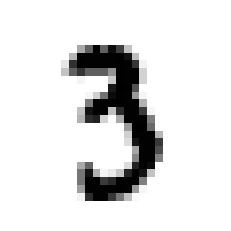

In [4]:
sample = X[74]
print(sample.shape)

plt.imshow(sample, cmap='binary')
plt.axis('off')

# Util stuff

Auxiliary functions needed to transform images, described in [Introduction to Convolutional Neural Networks](https://cs.nju.edu.cn/wujx/paper/CNN.pdf).

In [5]:
def vec(x):
    """Transform a matrix or 3-ord. tensor into vector in column major order."""
    
    return x.T.ravel()  # Works for ndim ≥ 2

In [6]:
def unvec(x, shape):
    """Reverse the above vectorization operation."""
    
    return x.reshape(shape[::-1]).T  # Works for ndim ≥ 2

In [7]:
def im_2_row(arr, shape, stride=1):  # Assert arr.ndim == 3
    """Transform an image into a matrix prepared for 2D matmul convolution in column major order.
    
    arr:     array to be transformed
    shape:   shape of the window
    stride:  step of the window
    
    returns: 2D matrix ready to multiply by a kernel matrix
    """
    return view_as_windows(arr.T, shape[::-1]).reshape(-1, np.prod(shape))

## Testing util stuff

In [8]:
class TestUtilStuff(unittest.TestCase):
    """Class testing above three functions"""

    def setUp(self):
        self.arr = np.array([2., 7., -4.7, 14.44, 0.0, 28., 19.7, 0.6, -7.6, 0.23])
        self.t = np.empty(shape=(4, 3, 2))
        self.t[:, :, 0] = np.array([[ 0.,  1.,  2.],
                                    [ 3.,  4.,  5.],
                                    [ 6.,  7.,  8.],
                                    [ 9., 10., 11.]])

        self.t[:, :, 1] = np.array([[12., 13., 14.],
                                    [15., 16., 17.],
                                    [18., 19., 20.],
                                    [21., 22., 23.]])
    
    def test_vec(self):
        np.testing.assert_array_equal(vec(self.arr), self.arr)
        np.testing.assert_array_equal(vec(self.t[:, :, 1]), np.array([12., 15., 18., 21., 13., 16.,
                                                                      19., 22., 14., 17., 20., 23.]))
        np.testing.assert_array_equal(vec(self.t), np.array([ 0.,  3.,  6.,  9.,  1.,  4.,
                                                              7., 10.,  2.,  5.,  8., 11.,
                                                             12., 15., 18., 21., 13., 16.,
                                                             19., 22., 14., 17., 20., 23.]))

    def test_unvec(self):
        np.testing.assert_array_equal(unvec(self.arr, shape=(2, 5)), np.array([[2.,  -4.7, 0.0, 19.7, -7.6],
                                                                               [7., 14.44, 28.,  0.6, 0.23]]))
        np.testing.assert_array_equal(unvec(np.array([12., 15., 18., 21., 13., 16.,
                                                      19., 22., 14., 17., 20., 23.]), shape=(4, 3)), self.t[:, :, 1])
        np.testing.assert_array_equal(unvec(np.array([ 0.,  3.,  6.,  9.,  1.,  4.,
                                                       7., 10.,  2.,  5.,  8., 11.,
                                                      12., 15., 18., 21., 13., 16.,
                                                      19., 22., 14., 17., 20., 23.]), shape=(4, 3, 2)), self.t)
        np.testing.assert_array_equal(unvec(vec(self.t[0, :, :]), shape=(3, 2)), self.t[0, :, :])
        np.testing.assert_array_equal(unvec(vec(self.t), shape=(4, 3, 2)), self.t)

    def test_im2row(self):
        second_channel_im2row = np.array([[12., 15., 18., 13., 16., 19.],
                                          [15., 18., 21., 16., 19., 22.],
                                          [13., 16., 19., 14., 17., 20.],
                                          [16., 19., 22., 17., 20., 23.]])
        total_t_im2row = np.array([[0., 3.,  6., 1., 4.,  7., 12., 15., 18., 13., 16., 19.],
                                   [3., 6.,  9., 4., 7., 10., 15., 18., 21., 16., 19., 22.],
                                   [1., 4.,  7., 2., 5.,  8., 13., 16., 19., 14., 17., 20.],
                                   [4., 7., 10., 5., 8., 11., 16., 19., 22., 17., 20., 23.]])
        np.testing.assert_array_equal(im_2_row(self.t[:, :, 1].reshape(4, 3, 1), shape=(3, 2, 1)), second_channel_im2row)
        np.testing.assert_array_equal(im_2_row(self.t, shape=(3, 2, 2)), total_t_im2row)

def suite():
    suite = unittest.TestSuite()
    suite.addTest(TestUtilStuff('test_vec'))
    suite.addTest(TestUtilStuff('test_unvec'))
    suite.addTest(TestUtilStuff('test_im2row'))
    return suite

runner = unittest.TextTestRunner()
runner.run(suite())

...
----------------------------------------------------------------------
Ran 3 tests in 0.003s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

# Layers implementation

All implemented formulas can be found in 2 papers mentioned at the beginning. The model is designed to work with stride equal to 1 in convolution and 2 in max pooling layers respectively only. Perhaps, the model works with different values of the parameters as it is implemented.

## ReLU

In [9]:
class ReLULayer:
    def __init__(self, input_shape):
        Hl, Wl, Dl = input_shape
        self.Hl = Hl
        self.Wl = Wl
        self.Dl = Dl
        
        self.Hll = Hl
        self.Wll = Wl
        self.Dll = Dl
    
    def get_output_shape(self):
        return self.Hll, self.Wll, self.Dll
    
    def get_backprop_signal(self):
        return unvec(vec(self.dz_dxl), shape=(self.Hl * self.Wl, self.Dl))
    
    
    def y(self, xl):
        self.xl = np.where(xl > 0.0, xl, 0.0)
        return self.xl
    
    
    def calculate_gradients(self, dz_over_dy):
        self.dz_over_dxl(dz_over_dy)
        
    def dz_over_dxl(self, dz_over_dy):
        dz_over_dy = unvec(vec(dz_over_dy), shape=(self.Hl, self.Wl, self.Dl))
        self.dz_dxl = np.where(self.xl > 0.0, dz_over_dy, 0.0)
        return self.dz_dxl
    
    def update_weights(self, lr):
        pass

Formulas implemented in the following layers include:
$$
    \phi(\mathbf{x}^l) = \text{im_2_row}(\mathbf{x}^l),
$$

$$
    vec(\mathbf{x}^{l+1}) = vec(\mathbf{y}) = vec(\mathbf{x}^{l+1}) = vec\big(\phi(\mathbf{x}^l)F\big),
$$
where $x^l$ is input into $l$th layer and $x^{l+1}=y$ is output of that layer, $F$ is layer's kernel in the shape required by input transformed by `im_to_row`.

Proper shapes are described by:
$$
\begin{split}
    H^{l+1} &= H^l - H + 1\\
    W^{l+1} &= W^l - W + 1.
\end{split}
$$

Gradients formulas are:
$$
    \frac{\partial z}{\partial F} = \phi(\mathbf{x}^l)^T \frac{\partial z}{\partial Y} = \phi(\mathbf{x}^l)^T \frac{\partial z}{\partial \mathbf{x}^{l+1}},
$$
$$
    \left[ \frac{\partial z}{\partial \mathbf{x}^l} \right]_{(i^l,j^l,d^l)} = \sum_{(p,q) \in m^{-1}(i^l,j^l,d^l)} \left[ \frac{\partial z}{\partial Y} F^T \right]_{(p,q)}
$$
where $z$ is the loss and $Y=y$.

## Conv

In [10]:
class ConvLayer:
    def __init__(self, H, W, D, input_shape):        
        self.H = H
        self.W = W
        self.D = D
        
        Hl, Wl, Dl = input_shape
        self.Hl = Hl
        self.Wl = Wl
        self.Dl = Dl
        
        self.Hll = Hl - H + 1
        self.Wll = Wl - H + 1
        self.Dll = D
        
        self.xl     = None
        self.dz_dF  = None
        self.dz_dxl = None
        self.init_kernel()
    
    def get_output_shape(self):
        return self.Hll, self.Wll, self.Dll
    
    def get_backprop_signal(self):
        return unvec(vec(self.dz_dxl), shape=(self.Hl * self.Wl, self.Dl))
    
    def init_kernel(self):  # Glorot uniform
        n_in  = self.Hl * self.Wl
        n_out = 1
        r = np.sqrt(6.0 / (n_in + n_out))
        self.F = np.random.uniform(-r, r, size=(self.H * self.W * self.Dl, self.D))
    
    
    def y(self, xl):
        self.xl = xl
        vec_y = vec(im_2_row(xl, shape=(self.H, self.W, self.Dl)) @ self.F)
        return unvec(vec_y, shape=(self.Hll, self.Wll, self.Dll))
    
    
    def calculate_gradients(self, dz_over_dy):
        self.dz_over_dF(dz_over_dy)
        self.dz_over_dxl(dz_over_dy)

    def dz_over_dF(self, dz_over_dy):
        self.dz_dF = im_2_row(self.xl, shape=(self.H, self.W, self.Dl)).T @ dz_over_dy
        return self.dz_dF

    def dz_over_dxl(self, dz_over_dy):
        Hl,  Wl, Dl = self.Hl,  self.Wl, self.Dl
        Hll, H,  W  = self.Hll, self.H,  self.W
        
        def m(p, q):
            jll, ill = divmod(p, Hll)
            dl = q // (H*W)
            j = q // H - W*dl
            i = q - H*j - H*W*dl
            il, jl = ill + i, jll + j
            return il, jl, dl

        res = np.empty((Hl, Wl, Dl))
        M = dz_over_dy @ self.F.T

        for p, row in enumerate(M):
            for q, elem in enumerate(row):
                il, jl, dl = m(p, q)
                res[il, jl, dl] = elem

        self.dz_dxl = res
        return self.dz_dxl
    
    def apply_gradient(self, grad):
        self.F = self.F + grad

## Max pooling

In [11]:
class MaxPoolingLayer:
    def __init__(self, input_shape):
        Hl, Wl, Dl = input_shape
        self.Hl = Hl
        self.Wl = Wl
        self.Dl = Dl
        
        self.Hll = Hl // 2
        self.Wll = Wl // 2
        self.Dll = Dl
        
        self.D = Dl
        
        self.xl     = None
        self.dz_dxl = None
        self.S = None  # Sparse matrix for backpropagation

    def get_output_shape(self):
        return self.Hll, self.Wll, self.Dll
    
    def get_backprop_signal(self):
        return unvec(vec(self.dz_dxl), shape=(self.Hl * self.Wl, self.Dl))
    
    def y(self, xl):
        self.xl = xl
        stride = 2
        Hl,  Wl,  Dl  = self.Hl,  self.Wl,  self.Dl
        Hll, Wll, Dll = self.Hll, self.Wll, self.Dll
        H, W = stride, stride

        xll = np.empty((Hll, Wll, Dll))
        S = np.empty(Hll*Wll*Dll, dtype=int)

        for ill in range(Hll):
            for jll in range(Wll):
                for dll in range(Dll):
                    i, j = np.unravel_index(np.argmax(xl[ill*H : ill*H + stride, jll*W : jll*W + stride, dll]),
                                            shape=(stride, stride))
                    il, jl, dl = ill*H + i, jll*W + j, dll
                    xll[ill, jll, dll] = xl[il, jl, dl]
                    S[ill + jll*Hll + dll*Hll*Wll] = il + jl*Hl + dl*Hl*Wl

        self.S = S
        return xll

    
    def calculate_gradients(self, dz_over_dy):
        self.dz_over_dxl(dz_over_dy)
    
    def dz_over_dxl(self, dz_over_dy):
        Hl,  Wl,  Dl  = self.Hl,  self.Wl,  self.Dl
        Hll, Wll, Dll = self.Hll, self.Wll, self.Dll
        S = self.S
        
        dz_over_dvecy = vec(dz_over_dy)

        res = np.zeros(Hl*Wl*Dl)
        for i, idx in enumerate(S):
            res[idx] += dz_over_dvecy[i]
        
        self.dz_dxl = unvec(res, shape=(Hl, Wl, Dl))
        return self.dz_dxl

## Softmax and cross-entropy

In [12]:
class SoftmaxLayer:
    def __init__(self, input_shape):  # assert input_shape[:-1] == (1, 1)
        N = input_shape[-1]
        self.N = N
        
        self.xl     = None
        self.dz_dxl = None
    
    def get_output_shape(self):
        return self.N
    
    def get_backprop_signal(self):
        return self.dz_dxl.reshape(1, 10)
    
    def y(self, xl):
        if xl.ndim > 1:
            xl = xl.ravel()

        self.xl = xl
        numerator = np.exp(xl)
        self.xll = numerator / np.sum(numerator)
        return self.xll
    
    def calculate_gradients(self, dz_over_dy):
        self.dz_over_dxl(dz_over_dy)
        
    def dz_over_dxl(self, target):
        self.dz_dxl = self.xll - target
        return self.dz_dxl

In [13]:
class CrossEntropyLayer:
    def __init__(self, input_shape):
        N = input_shape
        self.N = N
    
    def get_output_shape(self):
        return 1
    
    def get_backprop_signal(self):
        return self.target
    
    
    def z(self, xl, target):
        self.target = target
        self.term = xl @ target
        self.loss = -np.log(self.term)
        return self.loss

# Model

In [14]:
class Model:
    def __init__(self, lr):
        self.lr = lr
        self.prepare_stuff()
    
    def prepare_stuff(self):  # example architecture reaching reasonable performance
        self.layers = []

        self.layers.append(ConvLayer(5, 5, 5, (28, 28, 1)))
        self.layers.append(ReLULayer(self.layers[-1].get_output_shape()))
        
        self.layers.append(MaxPoolingLayer(self.layers[-1].get_output_shape()))
        
        self.layers.append(ConvLayer(3, 3, 15, self.layers[-1].get_output_shape()))
        self.layers.append(ReLULayer(self.layers[-1].get_output_shape()))
        
        self.layers.append(MaxPoolingLayer(self.layers[-1].get_output_shape()))
        
        self.layers.append(ConvLayer(5, 5, 80, self.layers[-1].get_output_shape()))
        self.layers.append(ReLULayer(self.layers[-1].get_output_shape()))
        self.layers.append(ConvLayer(1, 1, 10, self.layers[-1].get_output_shape()))
        
        self.layers.append(SoftmaxLayer(self.layers[-1].get_output_shape()))
        self.loss_layer = (CrossEntropyLayer(self.layers[-1].get_output_shape()))
        
        self.trainable = []
        
        for layer in self.layers:
            if isinstance(layer, ConvLayer):
                self.trainable.append(layer)
        self.trainable_size = len(self.trainable)


    def fit(self, X, Y, batch_size=32, epochs=2):
        X = X.copy()
        X = X.reshape(X.shape + (1,))
        n = len(X)
        Y_1d = Y
        
        Y = Y.copy()
        tmp = np.zeros((len(Y), 10), dtype=int)
        for i in range(len(Y)):
            tmp[i, Y[i]] = 1
        Y = tmp
        
        full_batches, rest = divmod(n, batch_size)
        n_batches = full_batches + (1 if rest else 0)
        for epoch in range(epochs):
            perm = np.random.permutation(n)
            X = X[perm]
            Y = Y[perm]
            Y_1d = Y_1d[perm]
            print(f'Epoch {epoch+1:2d}/{epochs}')
            loss = 0.0
            good_preds = 0
            for batch in range(n_batches):
                start, end = batch*batch_size, min((batch+1)*batch_size, n)
                
                batch_loss, batch_good_preds = self.mini_batch_fit(X[start: end], Y[start: end])
                loss += batch_loss
                good_preds += batch_good_preds
                
                acc = good_preds / min((batch + 1) * batch_size, n)
                avg_loss = loss / (batch+1)
                print(f'\rWent through: {end:3d}/{n} samples, '
                      f'avg_loss:{avg_loss:9.5f}, accuracy:{acc:5.4f}', end='')
            print('')
    
    def mini_batch_fit(self, X, Y):
        gradients = []
        size = len(X)
        
        image = X[0]
        x = self.feed_forward(image)
        good_preds = 1 if np.argmax(x) == np.argmax(Y[0]) else 0
        self.fire_backpropagation(x, Y[0])
        loss = self.loss_layer.loss
        
        for layer in self.trainable:
            gradients.append(layer.dz_dF.copy())
            
        for image, y in zip(X[1:], Y[1:]):
            x = self.feed_forward(image)
            good_preds += 1 if np.argmax(x) == np.argmax(y) else 0
            self.fire_backpropagation(x, y)
            loss += self.loss_layer.loss
            
            for i, layer in enumerate(self.trainable):
                gradients[i] += layer.dz_dF

        for layer, grad in zip(self.trainable, gradients):
            layer.apply_gradient(-self.lr*grad/size)
        
        return loss, good_preds
    
    def evaluate(self, X, Y):
        size = len(X)
        y = np.empty(size, dtype=int)
        for i, image in enumerate(X):
            y[i] = self.predict(image)
        
        acc = np.sum(y == Y) / size
        print(f'Accuracy: {acc:5.4f}')
    
    def feed_forward(self, x):
        if x.ndim == 2:
            x = x.reshape(28, 28, 1)
        for layer in self.layers:
            x = layer.y(x)
        return x
    
    def predict(self, x):
        return np.argmax(self.feed_forward(x))
    
    def fire_backpropagation(self, x, y):
        z = self.loss_layer.z(x, y)
        y = self.loss_layer.get_backprop_signal()
        for layer in self.layers[::-1]:
            layer.calculate_gradients(y)
            y = layer.get_backprop_signal()

# Model testing

In [15]:
model = Model(0.03)

In [16]:
%time model.fit(X_train, y_train, epochs=5)

Epoch  1/5
Went through: 60000/60000 samples, avg_loss: 11.33588, accuracy:0.8905
Epoch  2/5
Went through: 60000/60000 samples, avg_loss:  4.68386, accuracy:0.9559
Epoch  3/5
Went through: 60000/60000 samples, avg_loss:  3.71437, accuracy:0.9659
Epoch  4/5
Went through: 60000/60000 samples, avg_loss:  3.23627, accuracy:0.9697
Epoch  5/5
Went through: 60000/60000 samples, avg_loss:  2.85434, accuracy:0.9732
CPU times: user 6h 29min 3s, sys: 4h 43min 5s, total: 11h 12min 9s
Wall time: 2h 52min 52s


In [17]:
model.evaluate(X_test, y_test)

Accuracy: 0.9728


Above 97%, quite a result.